<div class="alert alert-block alert-info">
<b>Deadline:</b> March 15, 2023 (Wednesday) 23:00
</div>

# Exercise 1. Convolutional neural networks. LeNet-5.

In this exercise, you will train a very simple convolutional neural network used for image classification tasks.

You may find it useful to look at this tutorial:
* [Neural Networks](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py)

In [20]:
skip_training = True  # Set this flag to True before validation and submission

In [21]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

import tools, warnings
warnings.showwarning = tools.customwarn

In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tools
import tests

In [23]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is /coursedata


In [24]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [25]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

## FashionMNIST dataset

Let us use the FashionMNIST dataset. It consists of 60,000 training images of 10 classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'.

In [26]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
])

trainset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)

Let us visualize the data.

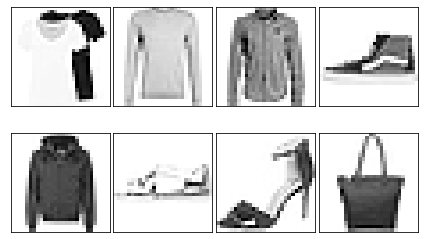

In [27]:
images, labels = next(iter(trainloader))
tests.plot_images(images[:8], n_rows=2)

# 1. Simple convolutional network

In the first exercise, your task is to create a convolutional neural network with the architecture inspired by the classical LeNet-5 [(LeCun et al., 1998)](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

The architecture of the convolutional network that you need to create:
* 2d convolutional layer with:
    * one input channel
    * 6 output channels
    * kernel size 5 (no padding)
    * followed by ReLU
* Max-pooling layer with kernel size 2 and stride 2
* 2d convolutional layer with:
    * 16 output channels
    * kernel size 5 (no padding)
    * followed by ReLU
* Max-pooling layer with kernel size 2 and stride 2
* A fully-connected layer with:
    * 120 outputs
    * followed by ReLU
* A fully-connected layer with:
    * 84 outputs
    * followed by ReLU
* A fully-connected layer with 10 outputs and without nonlinearity.

In [28]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # YOUR CODE HERE
        #First 2d CNN
        self.conv1 = nn.Conv2d(1,6,5)
        
        #Max-pooling layer with kernel size 2 and stride 2
        self.pool1 = nn.AvgPool2d(2,2)
        
        #Second 2d CNN
        self.conv2 = nn.Conv2d(6,16,5)
        
        #Max-pooling layer with kernel size 2 and stride 2
        self.pool2 = nn.AvgPool2d(2,2)
        
        #Fully Connected layer 1 with  120 outputs
        self.fc1 = nn.Linear(16*4*4, 120)
        
        #Fully connected layer 2 with 84 outputs
        self.fc2 = nn.Linear(120,84)
        
        #Fully coneccted layer with 10 outputs
        self.fc3 = nn.Linear(84,10)
        

    def forward(self, x):
        """
        Args:
          x of shape (batch_size, 1, 28, 28): Input images.
        
        Returns:
          y of shape (batch_size, 10): Outputs of the network.
        """
        # YOUR CODE HERE
        #Conv1 and Activation
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        #conv2 and activation
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        #Flatten the dimension
        x = torch.flatten(x,1)
        
        #Fully connected 1 and activation
        x = F.relu(self.fc1(x))
        
        #fully connected 2 with activation
        x = F.relu(self.fc2(x))

        #fully connected 3
        x = F.relu(self.fc3(x))
        
        return  x

In [29]:
def test_LeNet5_shapes():
    net = LeNet5()

    # Feed a batch of images from the training data to test the network
    with torch.no_grad():
        images, labels = next(iter(trainloader))
        print('Shape of the input tensor:', images.shape)

        y = net(images)
        assert y.shape == torch.Size([trainloader.batch_size, 10]), "Bad shape of y: y.shape={}".format(y.shape)

    print('Success')

test_LeNet5_shapes()

Shape of the input tensor: torch.Size([32, 1, 28, 28])
Success


In [30]:
def test_LeNet5():
    net = LeNet5()
    
    # get gradients for parameters in forward path
    net.zero_grad()
    x = torch.randn(1, 1, 28, 28)
    outputs = net(x)
    outputs[0,0].backward()
    
    parameter_shapes = sorted(tuple(p.shape) for p in net.parameters() if p.grad is not None)
    print(parameter_shapes)
    expected = [(6,), (6, 1, 5, 5), (10,), (10, 84), (16,), (16, 6, 5, 5), (84,), (84, 120), (120,), (120, 256)]
    assert parameter_shapes == expected, "Wrong number of training parameters."
    
    print('Success')

test_LeNet5()

[(6,), (6, 1, 5, 5), (10,), (10, 84), (16,), (16, 6, 5, 5), (84,), (84, 120), (120,), (120, 256)]
Success


# Train the network

In [38]:
# This function computes the accuracy on the test dataset
def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

### Training loop

Your task is to implement the training loop. The recommended hyperparameters:
* Stochastic Gradient Descent (SGD) optimizer with learning rate 0.001 and momentum 0.9.
* Cross-entropy loss. Note that we did not use softmax nonlinearity in the final layer of our network. Therefore, we need to use a loss function with log_softmax implemented, such as [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss).
* Number of epochs: 10. Please use mini-batches produces by `trainloader` defined above.

We recommend you to use function `compute_accuracy()` defined above to track the accuracy during training. The test accuracy should be above 0.87.

In [39]:
# Create network
net = LeNet5()

In [55]:
# Implement the training loop in this cell
if not skip_training:
    # YOUR CODE HERE
    # Upload the data already defined at the beggining of the script
    data = trainloader
    
    # define the loss function and optimizer
    optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(0,10):
        #net = net.train()
        for i, (data,target) in enumerate(trainloader,0):
            optimizer.zero_grad()
            output = net(data)
            loss =  criterion(output, target)
            loss.backward()
            optimizer.step()
        print("epoch: "+ str(epoch) + " with accuracy: "+ str(compute_accuracy(net, testloader)))


epoch: 0 with accuracy: 0.908
epoch: 1 with accuracy: 0.9086
epoch: 2 with accuracy: 0.9095
epoch: 3 with accuracy: 0.9083
epoch: 4 with accuracy: 0.9109
epoch: 5 with accuracy: 0.9084
epoch: 6 with accuracy: 0.9104
epoch: 7 with accuracy: 0.9098
epoch: 8 with accuracy: 0.909
epoch: 9 with accuracy: 0.9086


In [56]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(net, '1_lenet5.pth', confirm=True)

Do you want to save the model (type yes to confirm)? yes
Model saved to 1_lenet5.pth.


In [57]:
if skip_training:
    net = LeNet5()
    tools.load_model(net, '1_lenet5.pth', device)

Ground truth labels:  Ankle boot   Pullover    Trouser    Trouser      Shirt
Predictions:          Ankle boot   Pullover    Trouser    Trouser T-shirt/top


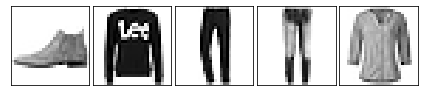

In [58]:
# Display random images from the test set, the ground truth labels and the network's predictions
net.eval()
with torch.no_grad():
    images, labels = iter(testloader).next()
    tests.plot_images(images[:5], n_rows=1)
    
    # Compute predictions
    images = images.to(device)
    y = net(images)

print('Ground truth labels: ', ' '.join('%10s' % classes[labels[j]] for j in range(5)))
print('Predictions:         ', ' '.join('%10s' % classes[j] for j in y.argmax(dim=1)))

In [59]:
# Compute the accuracy on the test set
accuracy = compute_accuracy(net, testloader)
print('Accuracy of the network on the test images: %.3f' % accuracy)
assert accuracy > 0.85, "Poor accuracy {:.3f}".format(accuracy)
print('Success')

Accuracy of the network on the test images: 0.909
Success
